In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [47]:
stats = pd.read_csv("./data/names-cleaned-stats.csv")

In [48]:
agg_stats = pd.read_csv("./data/sum_agg_stats.csv")

In [140]:
full_agg_stats = pd.read_csv("./data/agg_stats.csv")

In [51]:
stats.position.unique()

array(['All Rounder', 'Batsman', 'Bowler', 'Wicket Keeper',
       'Wicket-Keeper', 'Wicket keeper'], dtype=object)

In [55]:
position_dict = {"All Rounder": "AR", "Batsman": "BAT", "Bowler": "BWL", "Wicket Keeper": "WK", "Wicket-Keeper": "WK", "Wicket keeper": "WK"}
stats.replace(dict(position=position_dict), inplace=True)

### Merging position to full agg stats

In [60]:
position = stats[["player_name", "position"]].drop_duplicates(subset=["player_name"])

In [141]:
full_agg_stats_merged = pd.merge(full_agg_stats, position, right_on="player_name", left_on="PLAYER", how="inner")

### FULL AGG STATS contains stats for players in the auction and not the whole of IPL history

In [93]:
stats.head()

,year_position,player_name,year_points,matches,num_wkts,num_dots,num_fours,num_six,num_catches,num_stumpings,team_name,overseas_or_indian,ipl_year,position
0,1,ShaneWatson,406.5,15,17,158,47,19,2,0,RR,Overseas,2008,AR
1,30,ShaneWatson,166.0,6,6,61,18,9,3,0,RR,Overseas,2010,AR
2,5,ShaneWatson,246.0,11,6,78,31,17,4,0,RR,Overseas,2011,AR
3,23,ShaneWatson,202.0,7,6,62,26,14,2,0,RR,Overseas,2012,AR
4,1,ShaneWatson,386.0,16,13,101,59,22,6,0,RR,Overseas,2013,AR


In [80]:
points_bat_top = np.percentile(full_agg_stats_merged["Pts_mean"], 90)
points_bat_ab_avg = np.percentile(full_agg_stats_merged["Pts_mean"], 75)
points_bat_avg = np.percentile(full_agg_stats_merged["Pts_mean"], 50)
points_bowl_top = np.percentile(full_agg_stats_merged["Wkts_mean"], 90)
points_bowl_ab_avg = np.percentile(full_agg_stats_merged["Wkts_mean"], 75)
points_bowl_avg = np.percentile(full_agg_stats_merged["Wkts_mean"], 50)
points_dots_top = np.percentile(full_agg_stats_merged["Dots_mean"], 90)
points_dots_ab_avg = np.percentile(full_agg_stats_merged["Dots_mean"], 75)
points_dots_avg = np.percentile(full_agg_stats_merged["Dots_mean"], 50)
points_fours_top = np.percentile(full_agg_stats_merged["4s_mean"], 90)
points_fours_ab_avg = np.percentile(full_agg_stats_merged["4s_mean"], 75)
points_fours_avg = np.percentile(full_agg_stats_merged["4s_mean"], 50)
points_six_top = np.percentile(full_agg_stats_merged["6s_mean"], 90)
points_six_ab_avg = np.percentile(full_agg_stats_merged["6s_mean"], 75)
points_six_avg = np.percentile(full_agg_stats_merged["6s_mean"], 50)

In [94]:
def get_batting_rating(player_record):
    '''
    Get the batting rating alone for each player in a season.
    If the 
    '''
    batting_rating = 0.0
    year_pts = player_record["year_points"]
    num_fours = player_record["num_fours"]
    num_six = player_record["num_six"]
    
    '''
    On Points
    '''
    if  year_pts> points_bat_top:
        batting_rating+=50.0
    elif (year_pts > points_bat_ab_avg) and (year_pts <= points_bat_top):
        batting_rating+=25.0
    elif (year_pts > points_bat_avg) and (year_pts <= points_bat_ab_avg):
        batting_rating+=10.0
    else:
        batting_rating+=1.0
    
    '''
    On 4's
    '''
    if  num_fours> points_fours_top:
        batting_rating+=50.0
    elif (num_fours > points_fours_ab_avg) and (num_fours <= points_fours_top):
        batting_rating+=25.0
    elif (num_fours > points_fours_avg) and (num_fours <= points_fours_ab_avg):
        batting_rating+=10.0
    else:
        batting_rating+=1.0
        
    '''
    On 6's
    '''
    if  num_six> points_six_top:
        batting_rating+=50.0
    elif (num_six > points_six_ab_avg) and (num_six <= points_six_top):
        batting_rating+=25.0
    elif (num_six > points_six_avg) and (num_six <= points_six_ab_avg):
        batting_rating+=10.0
    else:
        batting_rating+=1.0
    
    return batting_rating

In [95]:
def get_bowling_rating(player_record):
    '''
    Get the bowling rating alone for each player in a season.
    If the 
    '''
    bowling_rating = 0.0
    year_pts = player_record["year_points"]
    num_wkts = player_record["num_wkts"]
    num_dots = player_record["num_dots"]
    
    '''
    On Points
    '''
    if  year_pts> points_bat_top:
        bowling_rating+=50.0
    elif (year_pts > points_bat_ab_avg) and (year_pts <= points_bat_top):
        bowling_rating+=25.0
    elif (year_pts > points_bat_avg) and (year_pts <= points_bat_ab_avg):
        bowling_rating+=10.0
    else:
        bowling_rating+=1.0
    
    '''
    On wickets
    '''
    if  num_wkts> points_bowl_top:
        bowling_rating+=50.0
    elif (num_wkts > points_bowl_ab_avg) and (num_wkts <= points_bowl_top):
        bowling_rating+=25.0
    elif (num_wkts > points_bowl_avg) and (num_wkts <= points_bowl_ab_avg):
        bowling_rating+=10.0
    else:
        bowling_rating+=1.0
        
    '''
    On dots
    '''
    if  num_dots> points_dots_top:
        bowling_rating+=50.0
    elif (num_dots > points_dots_ab_avg) and (num_dots <= points_dots_top):
        bowling_rating+=25.0
    elif (num_dots > points_dots_avg) and (num_dots <= points_dots_ab_avg):
        bowling_rating+=10.0
    else:
        bowling_rating+=1.0
    
    return bowling_rating

In [105]:
def get_positional_points(player_record):
    '''
    We give additional points to people who made it to the top 50 . This is to boost those special
    souls who did well in one -two season and then faded out.
    
    The rating is based on an inverse distribution.
    '''
    year_position = player_record["year_position"]
    return  50/year_position

In [102]:
def assign_rating_for_season(player_record):
    '''
    For each season the players position in the standings would be considered and depending on their position, 
    their respective stats would be considered and ratings would be summed up.
    
    All rounder -> 0.5 * Batting  + 0.5 * Bowling Rating
    Higher the better.
    '''
    
    position = player_record["position"]
    
    if (position == "BAT") or (position == "WK"):
        return (0.8 * get_batting_rating(player_record)) + (0.2 * get_positional_points(player_record))
    elif position == "BWL":
        return (0.8 * get_bowling_rating(player_record)) + (0.2 * get_positional_points(player_record))
    elif position == "AR":
        return (0.8 * ((0.5 * get_batting_rating(player_record)) + (0.5 * get_bowling_rating(player_record)))) + (0.2 * get_positional_points(player_record))

In [103]:
stats["season_rating_points"] = stats.apply(lambda x: assign_rating_for_season(x), axis=1)

### Merge median_season_rating_points to full_agg_stats
1. Median isn't suceptible to outliers

In [142]:
median_season_ratings = stats[["player_name", "season_rating_points"]].groupby(["player_name"]).agg(['median', 'mean']).reset_index(drop=False)
median_season_ratings.columns = ["player_name", "median_season_ratings", "avg_season_ratings"]

In [143]:
full_agg_stats_merged = pd.merge(full_agg_stats_merged, median_season_ratings, left_on="PLAYER", right_on="player_name", how="inner")

In [144]:
full_agg_stats_merged.drop(["player_name_x", "player_name_y"],axis=1, inplace=True)

In [145]:
full_agg_stats_merged.head()

,PLAYER,Pts_sum,Pts_mean,years_played,Mat_sum,Mat_mean,Wkts_sum,Wkts_mean,Dots_sum,Dots_mean,...,4s_mean,6s_sum,6s_mean,Catches_sum,Catches_mean,Stumpings_sum,Stumpings_mean,position,median_season_ratings,avg_season_ratings
0,ABdeVilliers,1712.5,155.681818,11,139,12.636364,0,0.000000,0,0.000000,...,28.909091,200,18.181818,80,7.272727,7,0.636364,BAT,80.344828,80.319112
1,AaronFinch,751.0,83.444444,9,75,8.333333,1,0.111111,13,1.444444,...,19.555556,67,7.444444,24,2.666667,0,0.000000,BAT,21.699010,43.901883
2,AbhishekJhunjhunwala,120.5,40.166667,3,21,7.000000,1,0.333333,27,9.000000,...,6.333333,5,1.666667,10,3.333333,0,0.000000,BAT,2.472464,7.289801
3,AbhishekNayar,340.5,48.642857,7,60,8.571429,9,1.285714,69,9.857143,...,7.857143,20,2.857143,13,1.857143,0,0.000000,BAT,2.480645,13.142476
4,AdamGilchrist,1091.5,181.916667,6,80,13.333333,1,0.166667,1,0.166667,...,39.833333,92,15.333333,51,8.500000,16,2.666667,WK,110.380747,94.764019


(array([70., 46., 20., 24., 11., 16., 20.,  7.,  9., 16.]),
 array([  2.45714286,  14.37809524,  26.29904762,  38.22      ,
         50.14095238,  62.06190476,  73.98285714,  85.90380952,
         97.8247619 , 109.74571429, 121.66666667]),
 <a list of 10 Patch objects>)

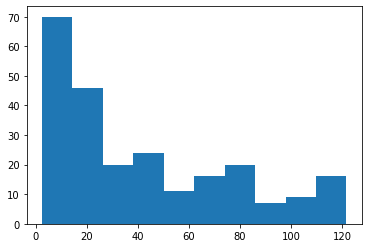

In [146]:
plt.hist(full_agg_stats_merged["median_season_ratings"])

(array([51., 34., 33., 28., 25., 30., 16., 15.,  4.,  3.]),
 array([  2.46241292,  14.35758577,  26.25275862,  38.14793147,
         50.04310431,  61.93827716,  73.83345001,  85.72862286,
         97.62379571, 109.51896856, 121.41414141]),
 <a list of 10 Patch objects>)

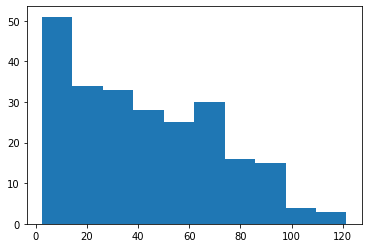

In [147]:
plt.hist(full_agg_stats_merged["avg_season_ratings"])

In [148]:
full_agg_stats_merged[["median_season_ratings", "avg_season_ratings"]].describe()

,median_season_ratings,avg_season_ratings
count,239.000000,239.000000
mean,40.396117,42.455601
std,35.868389,28.521220
min,2.457143,2.462413
25%,9.701525,17.933702
50%,26.568883,38.315780
75%,68.183873,63.799886
max,121.666667,121.414141


In [150]:
top25_percentile = full_agg_stats_merged[(full_agg_stats_merged["median_season_ratings"] > 68.183873) & (full_agg_stats_merged["avg_season_ratings"] > 63.799886)]

### Ideally we should try to get 11 players from here in this set

In [155]:
top25_percentile[top25_percentile.position=="WK"].sort_values(["median_season_ratings", "avg_season_ratings"], ascending=False)[["PLAYER", "median_season_ratings", "avg_season_ratings"]]

,PLAYER,median_season_ratings,avg_season_ratings
175,RishabhPant,110.964286,93.549723
4,AdamGilchrist,110.380747,94.764019
94,JosButtler,84.206697,84.342826
177,RobinUthappa,80.282194,82.002645
114,MSDhoni,80.235588,77.593702


In [152]:
top25_percentile[top25_percentile.position=="AR"].sort_values(["median_season_ratings"], ascending=False)[["PLAYER", "median_season_ratings"]]

,PLAYER,median_season_ratings
85,JacquesKallis,97.333333
12,AndreRussell,96.000000
24,AzharMahmood,94.500000
196,ShaneWatson,93.000000
104,KrunalPandya,86.000000
62,DwayneBravo,85.111111
23,AxarPatel,83.712500
214,SunilNarine,82.514286
43,ChrisMorris,79.829253
73,HardikPandya,72.833333


In [153]:
top25_percentile[top25_percentile.position=="BWL"].sort_values(["median_season_ratings"], ascending=False)[["PLAYER", "median_season_ratings"]]

,PLAYER,median_season_ratings
171,RashidKhan,121.666667
16,AnilKumble,121.000000
29,BhuvneshwarKumar,120.666667
108,LasithMalinga,120.526316
72,HarbhajanSingh,120.491071
132,MitchellMcClenaghan,120.400000
140,MunafPatel,120.384615
173,RavichandranAshwin,120.317540
195,ShaneWarne,110.488722
160,PraveenKumar,100.410509


In [154]:
top25_percentile[top25_percentile.position=="BAT"].sort_values(["median_season_ratings"], ascending=False)[["PLAYER", "median_season_ratings"]]

,PLAYER,median_season_ratings
230,VirenderSehwag,120.588235
53,DavidWarner,120.555556
216,SureshRaina,120.513158
40,ChrisGayle,120.476190
178,RohitSharma,110.639731
127,MatthewHayden,100.322581
229,ViratKohli,90.235135
0,ABdeVilliers,80.344828
63,DwayneSmith,80.270270
204,ShreyasIyer,80.238095


### Assigning Costs based on the rating distribution

In [163]:
# base price in crores
base_price_dict = {">90": 2, "80-90": 1.5, "60-80":1, "50-60": 0.75, "40-50": 0.5, "30-40": 0.4, "<30":0.3}
# Defining percentiles

median_ratings = full_agg_stats_merged["median_season_ratings"]
avg_ratings = full_agg_stats_merged["avg_season_ratings"]

In [162]:
def get_price(value, rating):
    if value > np.percentile(rating, 90):
        return base_price_dict[">90"]
    elif (value > np.percentile(rating, 80)) and (value <= np.percentile(rating, 90)):
        return base_price_dict["80-90"]
    elif (value > np.percentile(rating, 60)) and (value <= np.percentile(rating, 80)):
        return base_price_dict["60-80"]
    elif (value > np.percentile(rating, 50)) and (value <= np.percentile(rating, 60)):
        return base_price_dict["50-60"]
    elif (value > np.percentile(rating, 40)) and (value <= np.percentile(rating, 50)):
        return base_price_dict["40-50"]
    elif (value > np.percentile(rating, 30)) and (value <= np.percentile(rating, 40)):
        return base_price_dict["30-40"]
    else:
        return base_price_dict["<30"]

In [164]:
def get_base_price(player_record):
    median_rating = player_record["median_season_ratings"]
    avg_rating = player_record["avg_season_ratings"]
    return max(get_price(median_rating, median_ratings), get_price(avg_rating, avg_ratings))
    

In [165]:
full_agg_stats_merged["base_price"] = full_agg_stats_merged.apply(lambda x: get_base_price(x), axis=1)

In [168]:
full_agg_stats_merged.to_csv("./data/IPL-aggregated-stats_final.csv", index=False)